In [1]:
#add auto reload for src function testing
%load_ext autoreload
%autoreload 2

#let's add the project directory to our module path
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
#also import all of our modules
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from src import data_cleaning

#and here is our data directiory
data_folder = '../../data/'

# Objective

### In order to find which factors contribute to property value, we will look at the correlation between different nuisances like airport noise or power lines.

## Airport Noise

In [2]:
sales = pd.read_csv(data_folder+'EXTR_RPSale_2019.csv',dtype={'Major': 'string', 'Minor':'string', 'PIN': 'string'})
parcels = pd.read_csv(data_folder+'EXTR_Parcel_2019.csv',dtype={'Major': 'string', 'Minor':'string', 'PIN': 'string'})

In [3]:
sales.info()

parcels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42680 entries, 0 to 42679
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          42680 non-null  int64 
 1   ExciseTaxNbr        42680 non-null  int64 
 2   Major               42680 non-null  string
 3   Minor               42680 non-null  string
 4   DocumentDate        42680 non-null  object
 5   SalePrice           42680 non-null  int64 
 6   RecordingNbr        42680 non-null  object
 7   Volume              42680 non-null  object
 8   Page                42680 non-null  object
 9   PlatNbr             42680 non-null  object
 10  PlatType            42680 non-null  object
 11  PlatLot             42680 non-null  object
 12  PlatBlock           42680 non-null  object
 13  SellerName          42680 non-null  object
 14  BuyerName           42680 non-null  object
 15  PropertyType        42680 non-null  int64 
 16  PrincipalUse        42

In [4]:
sales_PINs = sales.loc[:, ['SalePrice', 'PIN']]
air_noise_PINs = parcels.loc[:,['AirportNoise', 'PIN']]

sales_vs_air_noise = pd.merge(sales_PINs, air_noise_PINs, on='PIN', how='inner')

In [5]:
sales_vs_air_noise

,SalePrice,PIN,AirportNoise
0,560000,2130430120,0
1,435000,9406520630,0
2,450000,1402810020,0
3,0,7797900030,0
4,193000,1245500098,0
...,...,...,...
42675,442000,4059400095,0
42676,680000,3816700025,0
42677,745000,6150200505,0
42678,0,3023000320,0


#### Let's check out the distribution of our data

/home/max/anaconda3/envs/housing/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


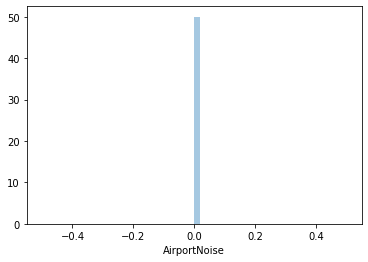

In [6]:
sns.distplot(sales_vs_air_noise.AirportNoise)

Looks like there aren't any properties with airport noise in this dataset. Let's checkout the spread of the data in the original parcels data.

/home/max/anaconda3/envs/housing/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


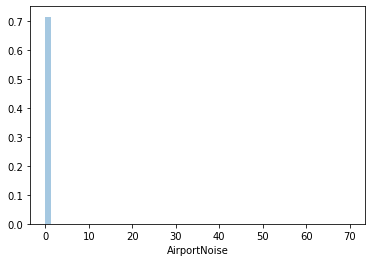

In [7]:
orig_parcels = pd.read_csv(data_folder+'EXTR_Parcel.csv', dtype={'Major': 'string', 'Minor':'string'}, encoding='iso8859_14')
sns.distplot(orig_parcels.AirportNoise)

looks like there's no airport noise in the data we have. Let's check traffic noise.

/home/max/anaconda3/envs/housing/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


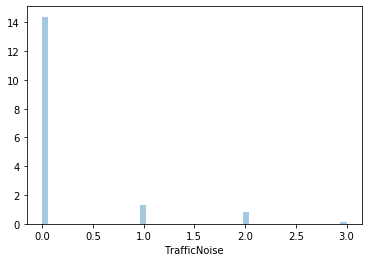

In [8]:
sns.distplot(orig_parcels.TrafficNoise)

Looks like there's a little data in the original dataset, let's see how ours compares

In [9]:
traffic_noise_PINs = parcels.loc[:,['TrafficNoise', 'PIN']]

sales_vs_traffic_noise = pd.merge(sales_PINs, traffic_noise_PINs, on='PIN', how='inner')

/home/max/anaconda3/envs/housing/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


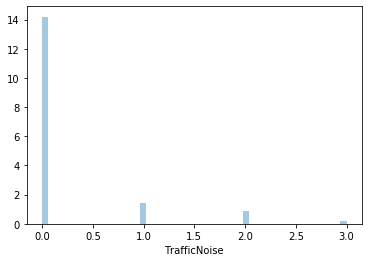

In [10]:
sns.distplot(sales_vs_traffic_noise.TrafficNoise)

In [11]:
sales_vs_traffic_noise.corr()

,SalePrice,TrafficNoise
SalePrice,1.000000,-0.020214
TrafficNoise,-0.020214,1.000000


In [12]:
def df_corr (df):
    """
    This function takes in a dataframe where the first column is the target 
    (dependent variable) and the rest are features to be analyzed. 
    We are looking for variables that are highly correlated with the target 
    variable.
    Returns a list of positively correlated variables and a list of 
    negatively correlated variables. Also plots the heatmap, pair plots, 
    and prints the results.
    """
    import seaborn as sns
    sns.set(rc={'figure.figsize':(8, 8)})
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    sns.heatmap(df.corr(), mask=mask);
    corrMatrix = df.corr()
    rows, cols = corrMatrix.shape
    flds = list(corrMatrix.columns)
    corr = df.corr().values
    neg_corr = []
    pos_corr = []
    print ("POSITIVE CORRELATIONS:")
    for j in range(1, cols):
        if corr[0,j] > 0.5:
            print ('     ', flds[0], ' ', flds[j], ' ', corr[0,j])
            pos_corr.append(flds[j])
    print ("NEGATIVE CORRELATIONS:")
    for j in range(1, cols):
        if corr[0,j] < -0.5:
            print ('     ', flds[0], ' ', flds[j], ' ', corr[0,j])
            neg_corr.append(flds[j])
    # Pair Plots
    df_pos = df[pos_corr]
    df_neg = df[neg_corr]
    sns.pairplot(df_pos)
    sns.pairplot(df_neg)
    return pos_corr, neg_corr


In [13]:
sale_and_parcels = pd.merge(sales, parcels, on='PIN', how='inner', suffixes=('_sales', '_parcels'))

POSITIVE CORRELATIONS:
NEGATIVE CORRELATIONS:


IndexError: index -1 is out of bounds for axis 0 with size 0

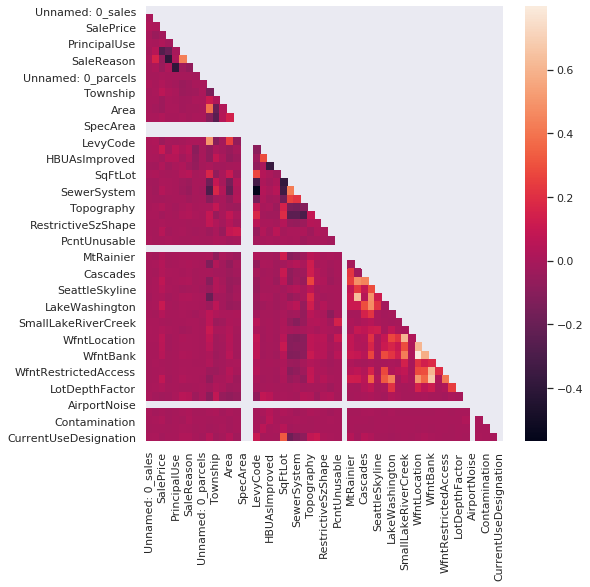

<Figure size 0x0 with 0 Axes>

In [14]:
pos, neg = df_corr(sale_and_parcels)

In [15]:
sales.columns

Index(['Unnamed: 0', 'ExciseTaxNbr', 'Major', 'Minor', 'DocumentDate',
       'SalePrice', 'RecordingNbr', 'Volume', 'Page', 'PlatNbr', 'PlatType',
       'PlatLot', 'PlatBlock', 'SellerName', 'BuyerName', 'PropertyType',
       'PrincipalUse', 'SaleInstrument', 'AFForestLand', 'AFCurrentUseLand',
       'AFNonProfitUse', 'AFHistoricProperty', 'SaleReason', 'PropertyClass',
       'SaleWarning', 'PIN'],
      dtype='object')

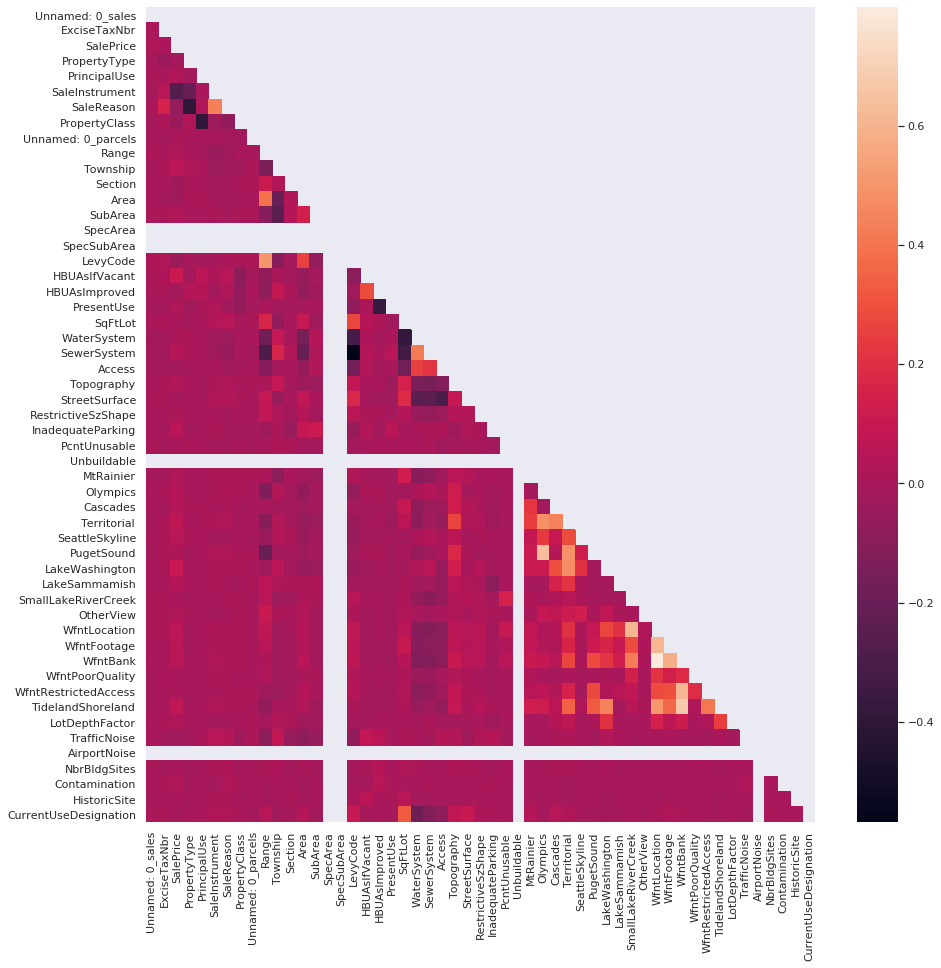

In [16]:
sns.set(rc={'figure.figsize':(15, 15)})
mask = np.triu(np.ones_like(sale_and_parcels.corr(), dtype=np.bool))
sns.heatmap(sale_and_parcels.corr(), mask=mask);
corrMatrix = sale_and_parcels.corr()

It looks like there is very little correlation between anything in the parcel dataframe and the saleprice

### Res_Bldg

In [17]:
res_bldg = pd.read_csv(data_folder+'EXTR_ResBldg_2019.csv', dtype={'Major':'string', 'Minor':'string', 'PIN':'string'})

In [18]:
sales_and_res = pd.merge(sales, res_bldg, on='PIN', how='inner', suffixes=('_sales', '_res'))

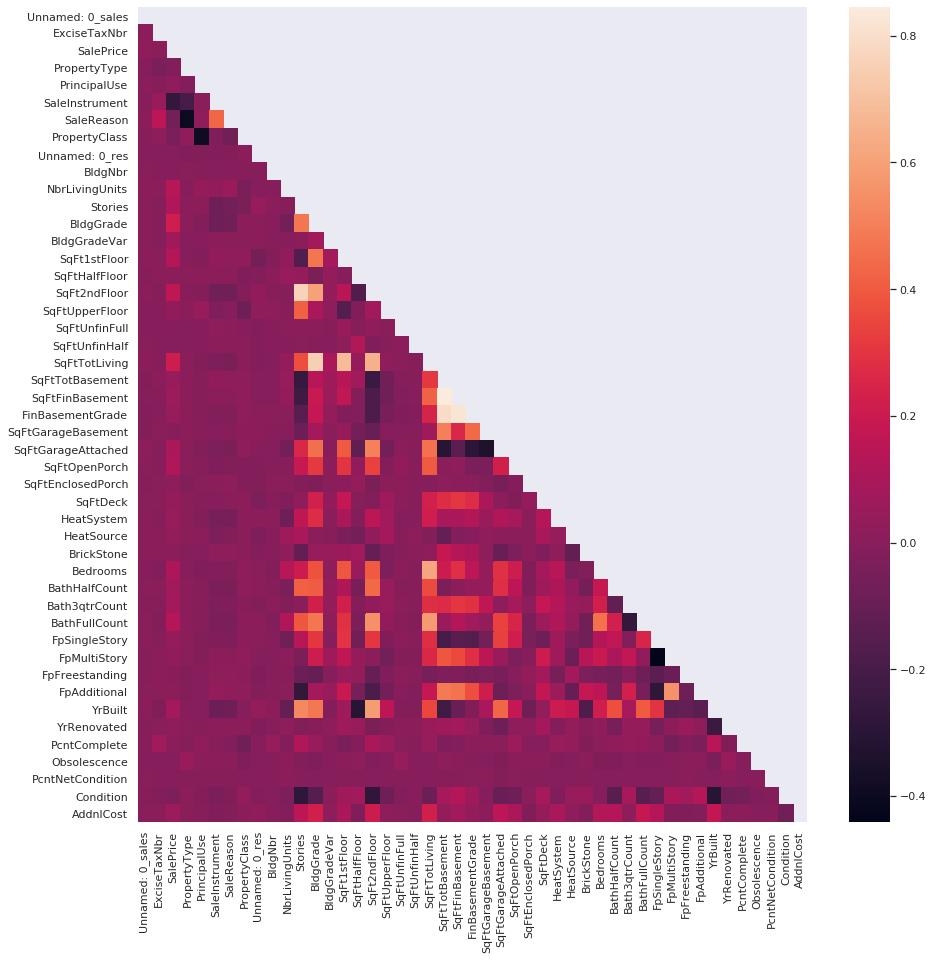

In [19]:
sns.set(rc={'figure.figsize':(15, 15)})
mask = np.triu(np.ones_like(sales_and_res.corr(), dtype=np.bool))
sns.heatmap(sales_and_res.corr(), mask=mask);
corrMatrix = sales_and_res.corr()

In [20]:
sales_and_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42680 entries, 0 to 42679
Data columns (total 77 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0_sales    42680 non-null  int64  
 1   ExciseTaxNbr        42680 non-null  int64  
 2   Major_sales         42680 non-null  string 
 3   Minor_sales         42680 non-null  string 
 4   DocumentDate        42680 non-null  object 
 5   SalePrice           42680 non-null  int64  
 6   RecordingNbr        42680 non-null  object 
 7   Volume              42680 non-null  object 
 8   Page                42680 non-null  object 
 9   PlatNbr             42680 non-null  object 
 10  PlatType            42680 non-null  object 
 11  PlatLot             42680 non-null  object 
 12  PlatBlock           42680 non-null  object 
 13  SellerName          42680 non-null  object 
 14  BuyerName           42680 non-null  object 
 15  PropertyType        42680 non-null  int64  
 16  Prin

The correlation between anything and saleprice is extremely weak. I'm going to try seeing what the distribution of sales prices look like.

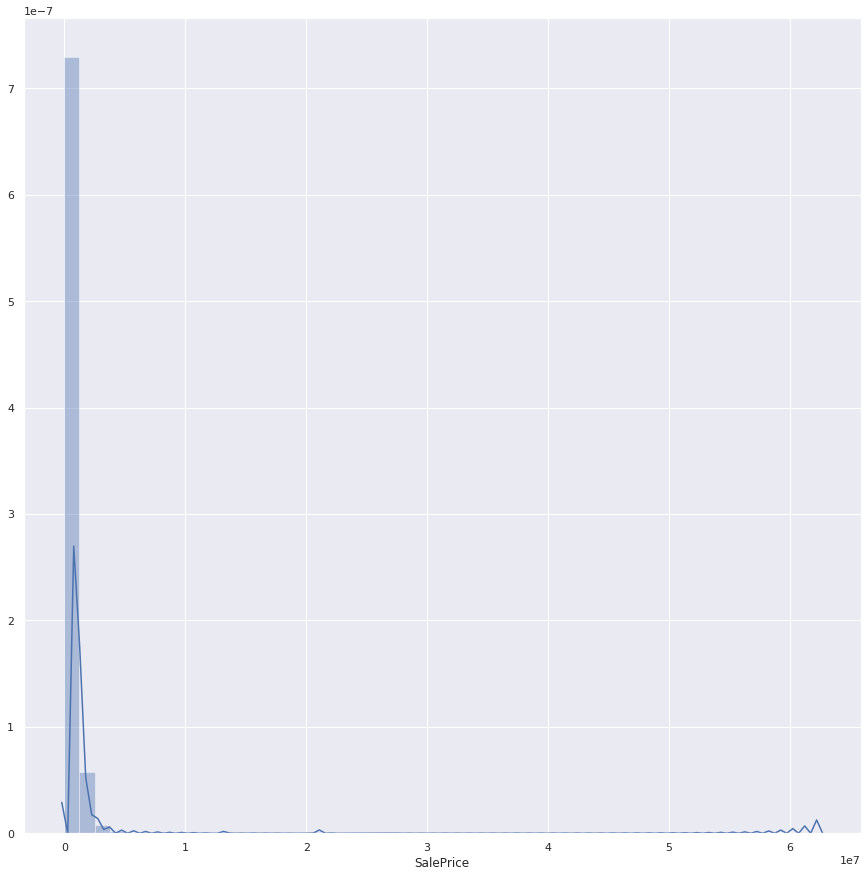

In [21]:
sns.distplot(sales.SalePrice)

In [22]:
sales.SalePrice.describe()

count    4.268000e+04
mean     5.897236e+05
std      1.142212e+06
min     -3.000000e+02
25%      0.000000e+00
50%      4.850000e+05
75%      7.750000e+05
max      6.250000e+07
Name: SalePrice, dtype: float64

In [23]:
prices = sales.SalePrice

In [24]:
no_outliers = prices[(prices>0)&(prices<5000000)]

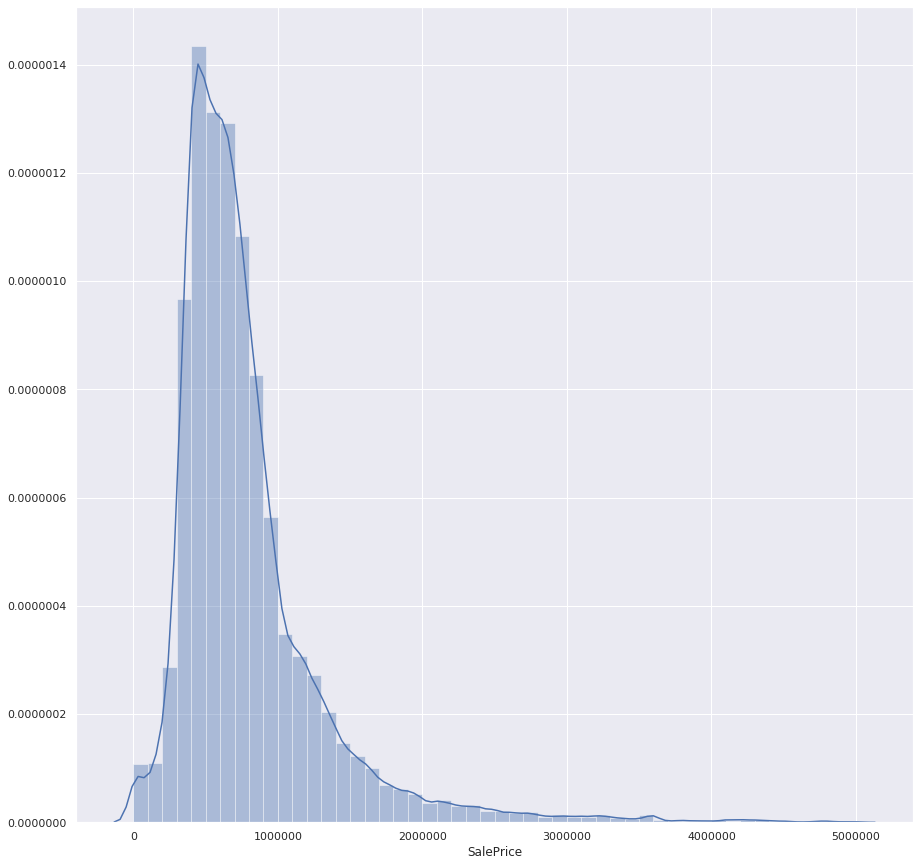

In [25]:
sns.distplot(no_outliers)

This looks more realisitic, so let's apply this to our main dataframe.

In [26]:
sales_no_outliers = sales[(sales['SalePrice']>0)&(sales['SalePrice']<5000000)]

In [27]:
sales_and_res = pd.merge(sales_no_outliers, res_bldg, on='PIN', how='inner', suffixes=('_sales', '_res'))

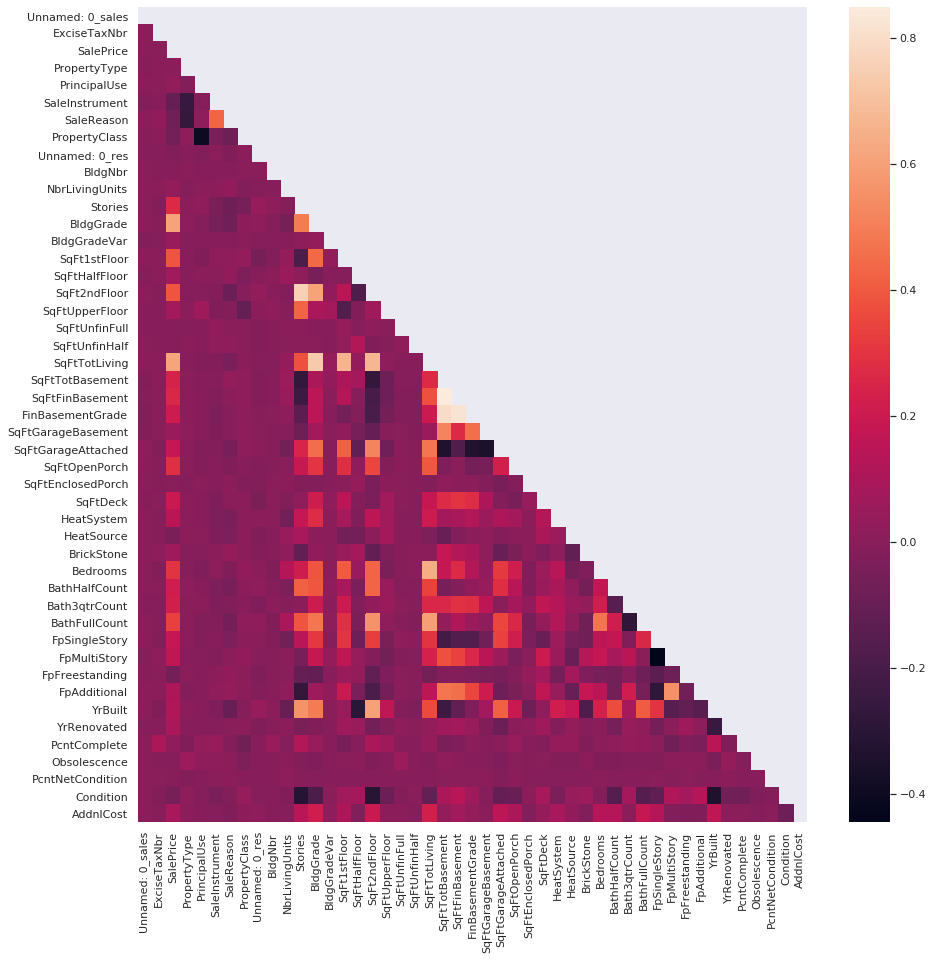

In [28]:
sns.set(rc={'figure.figsize':(15, 15)})
mask = np.triu(np.ones_like(sales_and_res.corr(), dtype=np.bool))
sns.heatmap(sales_and_res.corr(), mask=mask);
corrMatrix = sales_and_res.corr()

In [49]:
only_sales = sales[(sales['SaleReason']==1)|(sales['SaleReason']==18)]
only_sales

,Unnamed: 0,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,...,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,PIN
0,257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,...,6,3,N,N,N,N,1,8,,2130430120
1,302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,...,6,3,N,N,N,N,1,8,,9406520630
2,465,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,...,6,3,N,N,N,N,1,8,,1402810020
3,482,3015516,779790,0030,2019-10-07,0,20191016000009,,,,...,6,3,N,N,N,N,1,8,,7797900030
4,594,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,...,6,15,N,N,N,N,18,8,18 51 52,1245500098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42675,2087770,2992593,405940,0095,2019-05-21,442000,20190607001670,,,,...,6,3,N,N,N,N,1,8,,4059400095
42676,2087773,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,...,6,3,N,N,N,N,1,8,,3816700025
42677,2087774,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,...,6,3,N,N,N,N,1,8,,6150200505
42678,2087900,2997920,302300,0320,2019-05-01,0,20190705000539,,,,...,6,15,N,N,N,N,1,8,,3023000320


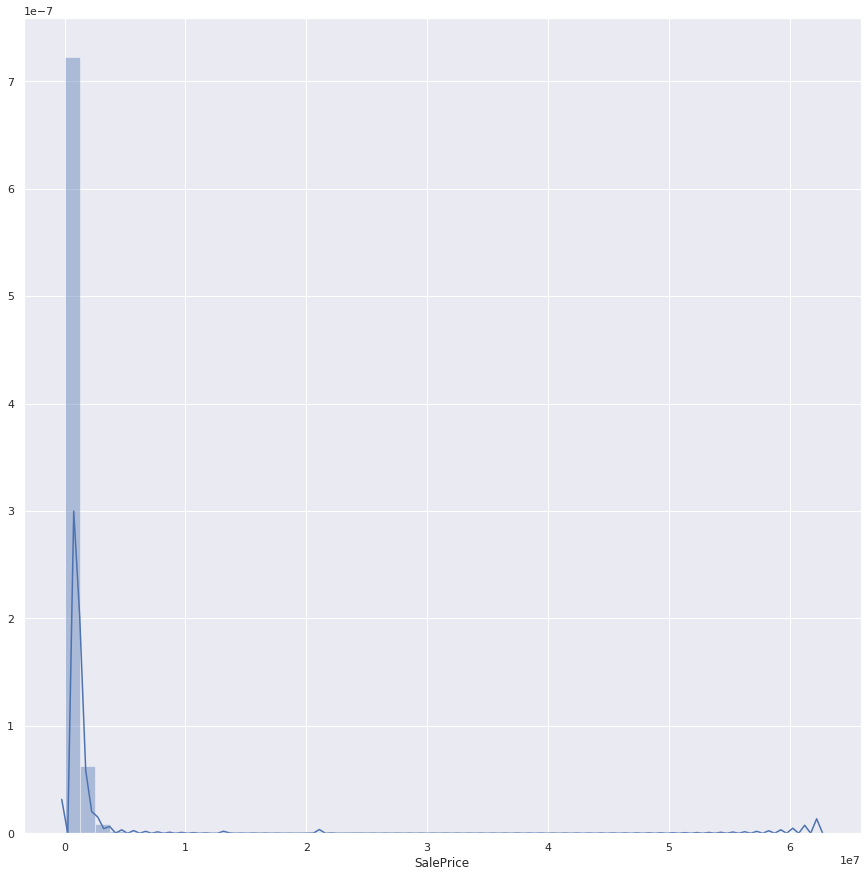

In [33]:
sns.distplot(only_sales.SalePrice)

In [51]:
res_sales= only_sales[(only_sales['PropertyClass'] == 7)|(only_sales['PropertyClass'] == 8)]
res_sales

,Unnamed: 0,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,...,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,PIN
0,257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,...,6,3,N,N,N,N,1,8,,2130430120
1,302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,...,6,3,N,N,N,N,1,8,,9406520630
2,465,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,...,6,3,N,N,N,N,1,8,,1402810020
3,482,3015516,779790,0030,2019-10-07,0,20191016000009,,,,...,6,3,N,N,N,N,1,8,,7797900030
4,594,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,...,6,15,N,N,N,N,18,8,18 51 52,1245500098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42675,2087770,2992593,405940,0095,2019-05-21,442000,20190607001670,,,,...,6,3,N,N,N,N,1,8,,4059400095
42676,2087773,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,...,6,3,N,N,N,N,1,8,,3816700025
42677,2087774,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,...,6,3,N,N,N,N,1,8,,6150200505
42678,2087900,2997920,302300,0320,2019-05-01,0,20190705000539,,,,...,6,15,N,N,N,N,1,8,,3023000320


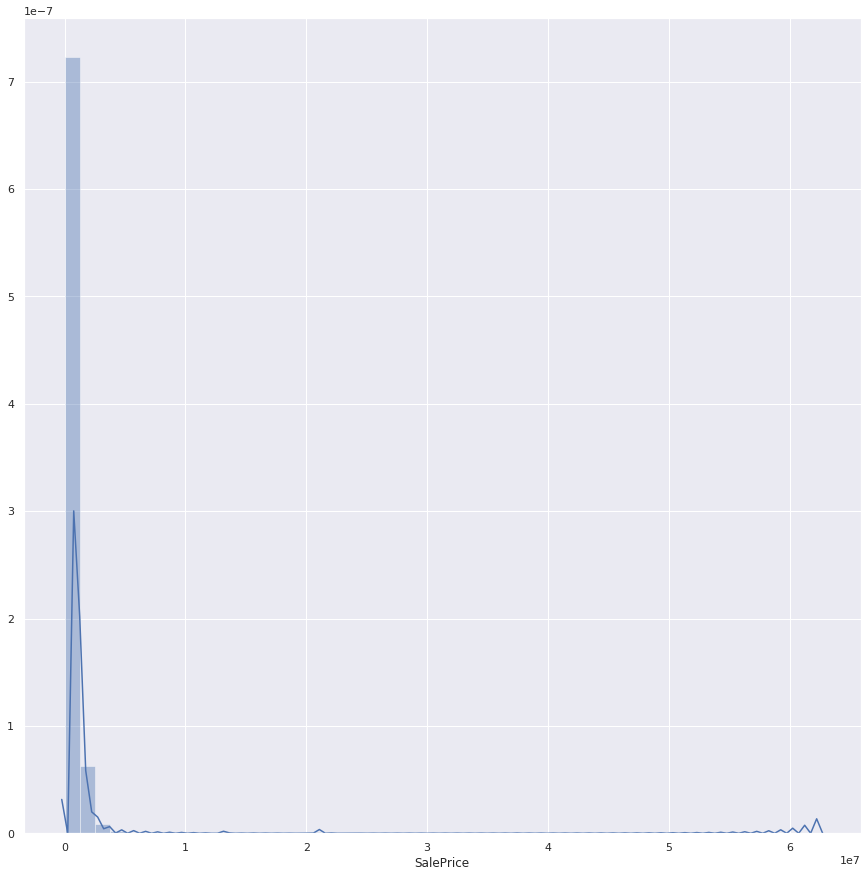

In [39]:
sns.distplot(res_sales.SalePrice)

In [43]:
z = np.abs(stats.zscore(res_sales.SalePrice))
res_sales[z < 3]

,Unnamed: 0,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,...,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,PIN
0,257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,...,6,3,N,N,N,N,1,8,,2130430120
1,302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,...,6,3,N,N,N,N,1,8,,9406520630
2,465,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,...,6,3,N,N,N,N,1,8,,1402810020
3,482,3015516,779790,0030,2019-10-07,0,20191016000009,,,,...,6,3,N,N,N,N,1,8,,7797900030
4,594,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,...,6,15,N,N,N,N,18,8,18 51 52,1245500098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42675,2087770,2992593,405940,0095,2019-05-21,442000,20190607001670,,,,...,6,3,N,N,N,N,1,8,,4059400095
42676,2087773,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,...,6,3,N,N,N,N,1,8,,3816700025
42677,2087774,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,...,6,3,N,N,N,N,1,8,,6150200505
42678,2087900,2997920,302300,0320,2019-05-01,0,20190705000539,,,,...,6,15,N,N,N,N,1,8,,3023000320


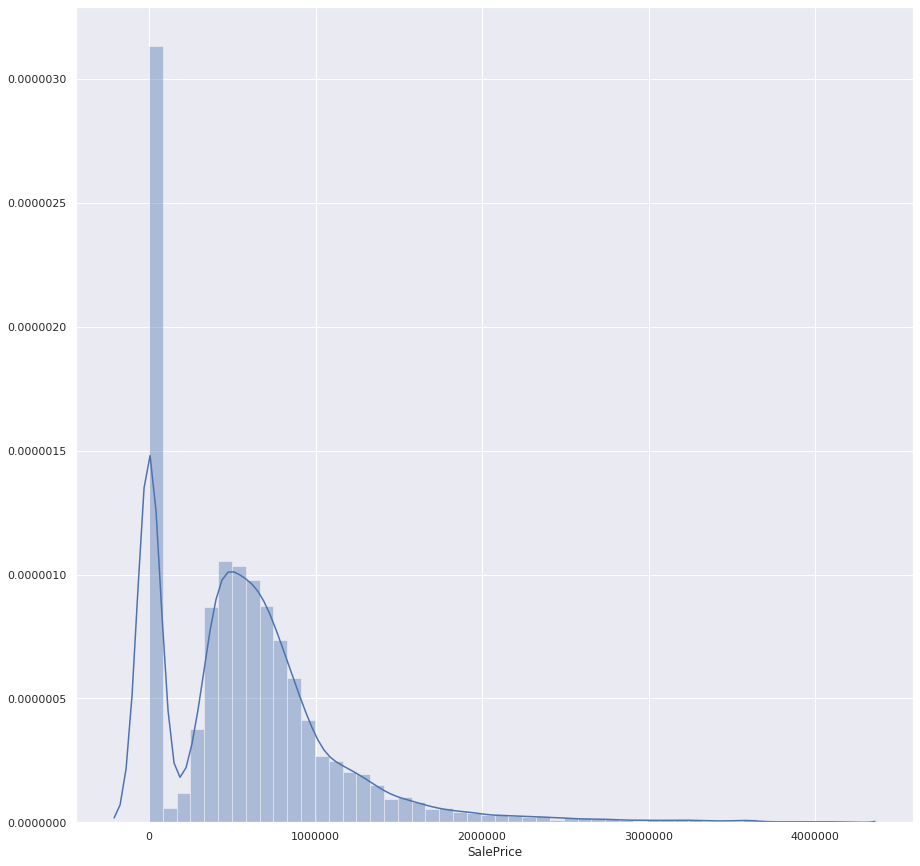

In [44]:
sns.distplot(res_sales[z < 3].SalePrice)

In [45]:
res_sales = res_sales[res_sales['SalePrice'] !=0]

In [46]:
z = np.abs(stats.zscore(res_sales.SalePrice))
res_sales[z < 3]

,Unnamed: 0,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,...,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,PIN
0,257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,...,6,3,N,N,N,N,1,8,,2130430120
1,302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,...,6,3,N,N,N,N,1,8,,9406520630
2,465,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,...,6,3,N,N,N,N,1,8,,1402810020
4,594,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,...,6,15,N,N,N,N,18,8,18 51 52,1245500098
5,599,2980648,797320,2320,2019-03-27,540000,,,,,...,6,3,N,N,N,N,1,8,,7973202320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42674,2087715,2972689,929085,0760,2019-01-25,1205000,20190206001611,,,,...,6,24,N,N,N,N,18,8,12,9290850760
42675,2087770,2992593,405940,0095,2019-05-21,442000,20190607001670,,,,...,6,3,N,N,N,N,1,8,,4059400095
42676,2087773,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,...,6,3,N,N,N,N,1,8,,3816700025
42677,2087774,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,...,6,3,N,N,N,N,1,8,,6150200505


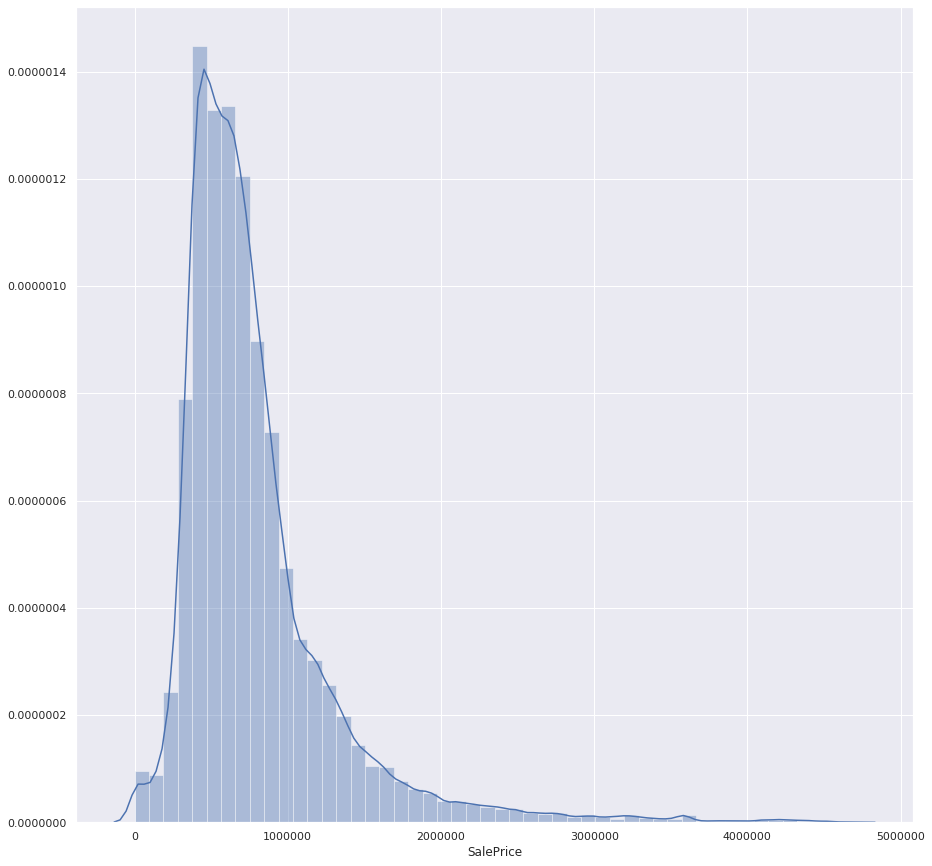

In [47]:
sns.distplot(res_sales[z < 3].SalePrice)

In [48]:
res_sales

,Unnamed: 0,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,...,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,PIN
0,257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,...,6,3,N,N,N,N,1,8,,2130430120
1,302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,...,6,3,N,N,N,N,1,8,,9406520630
2,465,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,...,6,3,N,N,N,N,1,8,,1402810020
4,594,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,...,6,15,N,N,N,N,18,8,18 51 52,1245500098
5,599,2980648,797320,2320,2019-03-27,540000,,,,,...,6,3,N,N,N,N,1,8,,7973202320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42674,2087715,2972689,929085,0760,2019-01-25,1205000,20190206001611,,,,...,6,24,N,N,N,N,18,8,12,9290850760
42675,2087770,2992593,405940,0095,2019-05-21,442000,20190607001670,,,,...,6,3,N,N,N,N,1,8,,4059400095
42676,2087773,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,...,6,3,N,N,N,N,1,8,,3816700025
42677,2087774,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,...,6,3,N,N,N,N,1,8,,6150200505


In [52]:
res_sales[res_sales['SalePrice']!=0]

,Unnamed: 0,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,...,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,PIN
0,257,3027422,213043,0120,2019-12-20,560000,20191226000848,,,,...,6,3,N,N,N,N,1,8,,2130430120
1,302,3002257,940652,0630,2019-07-22,435000,20190730001339,,,,...,6,3,N,N,N,N,1,8,,9406520630
2,465,2993601,140281,0020,2019-06-04,450000,20190614000489,,,,...,6,3,N,N,N,N,1,8,,1402810020
4,594,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,...,6,15,N,N,N,N,18,8,18 51 52,1245500098
5,599,2980648,797320,2320,2019-03-27,540000,,,,,...,6,3,N,N,N,N,1,8,,7973202320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42674,2087715,2972689,929085,0760,2019-01-25,1205000,20190206001611,,,,...,6,24,N,N,N,N,18,8,12,9290850760
42675,2087770,2992593,405940,0095,2019-05-21,442000,20190607001670,,,,...,6,3,N,N,N,N,1,8,,4059400095
42676,2087773,3003079,381670,0025,2019-07-22,680000,20190802000628,,,,...,6,3,N,N,N,N,1,8,,3816700025
42677,2087774,3025068,615020,0505,2019-11-18,745000,20191212000602,,,,...,6,3,N,N,N,N,1,8,,6150200505
